In [23]:
%env CUDA_VISIBLE_DEVICES=0
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

env: CUDA_VISIBLE_DEVICES=0
env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [24]:
import os
import sys
if os.getcwd().split("/")[-1] == "notebooks":
    %cd ..
sys.path.append(".")
None

In [25]:
import jax
from jax import numpy as jnp
from flax.training import checkpoints

from npf.jax.models import (
    CNP, CANP,
    NP, ANP,
    BNP, BANP,
    NeuBNP, NeuBANP,
    ConvCNP,
)
from npf.jax.data import build_dataloader
from npf.jax._data import GPSampler
sample_for_plot = GPSampler.sample_for_plot

from matplotlib import pyplot as plt
from nxcl.config import load_config, ConfigDict

In [26]:
ckpt_dir = "outs/_/220704-181313-vweh"

In [27]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(style="white")
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

palette = sns.color_palette()

def plot_1d(axes, x_ctx, y_ctx, x_tar, y_tar, mu_tar, sigma_tar, mask_ctx, mask_tar):
    batch_num = x_ctx.shape[0]
    flat_axes = axes.flatten()

    for i in range(batch_num):
        x_i_ctx = [x.item() for x, m in zip(x_ctx[i], mask_ctx[i]) if m]
        y_i_ctx = [y.item() for y, m in zip(y_ctx[i], mask_ctx[i]) if m]
        x_i_tar = [x.item() for x, m in zip(x_tar[i], mask_tar[i]) if m]
        y_i_tar = [y.item() for y, m in zip(y_tar[i], mask_tar[i]) if m]
        sns.scatterplot(x=x_i_ctx, y=y_i_ctx, ax=flat_axes[i], color=palette[3])
        sns.lineplot(x=x_i_tar, y=y_i_tar, ax=flat_axes[i], color=palette[2])
        if len(mu_tar.shape) == 4:
            for j in range(mu_tar.shape[1]):
                m_i_tar = [u.item() for u, m in zip(mu_tar[i, j], mask_tar[i]) if m]
                ub_i_tar = [u.item() - s.item() for u, s, m in zip(mu_tar[i, j], sigma_tar[i, j], mask_tar[i]) if m]
                lb_i_tar = [u.item() + s.item() for u, s, m in zip(mu_tar[i, j], sigma_tar[i, j], mask_tar[i]) if m]
                sns.lineplot(x=x_i_tar, y=m_i_tar, ax=flat_axes[i], color=palette[0], alpha=0.5)
                flat_axes[i].fill_between(x_i_tar, lb_i_tar, ub_i_tar, color=palette[0], alpha=0.1)
        else:
            m_i_tar = [u.item() for u, m in zip(mu_tar[i], mask_tar[i]) if m]
            ub_i_tar = [u.item() - s.item() for u, s, m in zip(mu_tar[i], sigma_tar[i], mask_tar[i]) if m]
            lb_i_tar = [u.item() + s.item() for u, s, m in zip(mu_tar[i], sigma_tar[i], mask_tar[i]) if m]
            sns.lineplot(x=x_i_tar, y=m_i_tar, ax=flat_axes[i], color=palette[0])
            flat_axes[i].fill_between(x_i_tar, lb_i_tar, ub_i_tar, color=palette[0], alpha=0.3)

In [28]:
config: ConfigDict = load_config(f"{ckpt_dir}/config.yaml")

models = {
    "CNP":     CNP,
    "NP":      NP,
    "CANP":    CANP,
    "ANP":     ANP,
    "BNP":     BNP,
    "BANP":    BANP,
    "NeuBNP":  NeuBNP,
    "NeuBANP": NeuBANP,
    "ConvCNP": ConvCNP,
}

if config.model.name not in models:
    raise ValueError(f"Unknown model: {config.model.name}")

model = models[config.model.name](
    y_dim=config.datasets.shapes.y_ctx[-1],
    **config.model.get("kwargs", {}),
)

state = checkpoints.restore_checkpoint(ckpt_dir, prefix="ckpt_best_ll_", target=None)

In [32]:
seed = 1
key, model_key = jax.random.split(jax.random.PRNGKey(seed), 2)
dataset = build_dataloader(config.datasets.test, key, None).dataset
# dataset.sample_gp_for_plot = lambda *args, **kwargs: sample_gp_for_plot(dataset, *args, **kwargs)

# Warning: This code uses legacy code. It will be changed to use the new API in the future.
x, y, x_ctx, x_tar, y_ctx, y_tar, mask, mask_ctx, mask_tar = sample_for_plot(dataset, key, num_points=100, num_ctx=10)

In [33]:
mu_tar, sigma_tar = model.apply(
    state["params"],
    x_ctx=x_ctx,
    y_ctx=y_ctx,
    x_tar=x_tar,
    mask_ctx=mask_ctx,
    mask_tar=mask_tar,
    rngs=dict(sample=model_key),
    **config.model.get("test_kwargs", {})
)

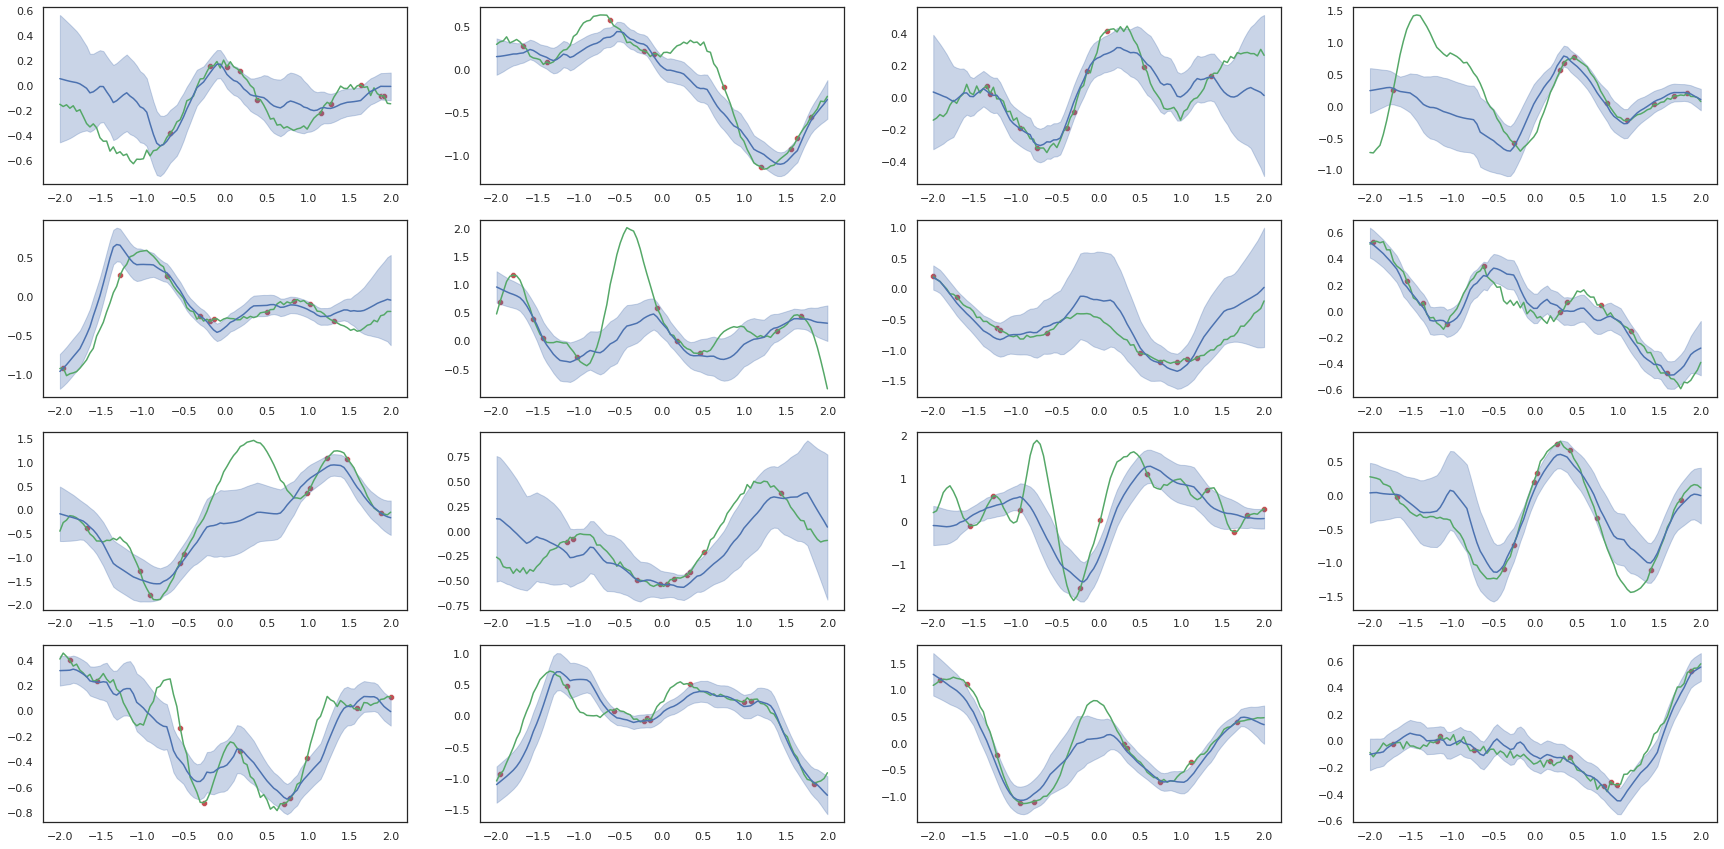

In [34]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(30, 15))
plot_1d(axes, x_ctx, y_ctx, x_tar, y_tar, mu_tar, sigma_tar, mask_ctx, mask_tar)
fig.show()